## Preprocessing and LDA Topic Modelling Notebook <br>
This notebook aims to preprocess string data from Gcash App Store reviews to then fit into a topic model which will semantically create overarching topics.

In [3]:
# importing libraries
import pandas as pd
import regex as re
import numpy as np
import tqdm
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
import contractions
from textblob import TextBlob
from nltk.tokenize import word_tokenize
import json

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim import models

import spacy
import umap.umap_ as umap

from pprint import pprint

import seaborn as sns

import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV

D:\Anaconda3\envs\project-env-2\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


References: <br>
https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0 <br>
https://www.programmersought.com/article/86852802169/ <br>
Patrick and Mico's notebooks 

In [4]:
def import_csv(path):
    reviews = pd.read_csv(path)
    reviews['title_review'] = reviews['title'] + ' ' + reviews['review']
    reviews = reviews.drop(['userName','title','review','isEdited','app_id','developerResponse','app_name'],axis=1)
    return reviews

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
gcash_reviews = import_csv('/Mynt Capstone/data/gcash_appstore_612020_622021.csv')

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
gcash_reviews.head()

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,rating,title_review
0,2020-06-07 04:57:17,5,Gcash user since 2018 I've been using gcash fo...
1,2021-01-12 09:46:26,5,Read please!! Those others who doesn’t like gc...
2,2020-07-16 05:22:48,2,Delayed Payment Reflection GCash serves as a r...
3,2021-02-17 09:15:31,5,7 years and counting Been using gcash for 7 ye...
4,2020-07-06 06:55:09,1,Worst Customer Service Ever!!!!!!! My old acco...


In [7]:
# Remove emojis and emoticons

# Code block 1: remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

#Example
remove_emoji("Have fun with NLP! 😃😃")

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'Have fun with NLP! '

In [8]:
# Function for removing emoticons
def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    return emoticon_pattern.sub(r'', text)

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# Function for removing URL's
def remove_urls (vTEXT):
    vTEXT = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', vTEXT, flags=re.MULTILINE)
    return(vTEXT)

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Preprocessing Function

In [10]:
def preprocess(corpus, column):
    corpus[column].dropna(inplace=True) # Drop blank rows
    corpus[column] = [entry.lower() for entry in corpus[column]] # Lowercase text
    corpus[column] = corpus[column].apply(lambda x: remove_emoji(x)) #Remove emoji's
    corpus[column] = corpus[column].apply(lambda x: remove_emoticons(x)) #Remove emoticons
    corpus[column] = corpus[column].apply(lambda x: remove_urls(x)) #Remove URL's
    corpus[column] = corpus[column].apply(lambda x: contractions.fix(x)) # Expand contractions
    corpus[column] = corpus[column].apply(lambda x: str(TextBlob(x))) # Correct spelling
    corpus[column] = corpus[column].str.replace("[^a-zA-Z#]", " ") # Remove unwanted characters, numbers and symbols
    corpus[column] = corpus[column].str.replace(r'\r+|\n+|\t+','', regex=True) #Remove \n \t \r
    corpus[column] = corpus[column].str.replace('[^\w\s]','') # Remove punctuation

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:11: DeprecationWarning: invalid escape sequence \w
<>:11: DeprecationWarning: invalid escape sequence \w
<ipython-input-10-7433b03a1d38>:11: DeprecationWarning: invalid escape sequence \w
  corpus[column] = corpus[column].str.replace('[^\w\s]','') # Remove punctuation


In [11]:
preprocess(gcash_reviews, 'title_review')

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-10-7433b03a1d38>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  corpus[column] = corpus[column].str.replace("[^a-zA-Z#]", " ") # Remove unwanted characters, numbers and symbols
<ipython-input-10-7433b03a1d38>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  corpus[column] = corpus[column].str.replace('[^\w\s]','') # Remove punctuation


In [12]:
gcash_reviews.head(10)

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,rating,title_review
0,2020-06-07 04:57:17,5,gcash user since I have been using gcash ...
1,2021-01-12 09:46:26,5,read please those others who does not like g...
2,2020-07-16 05:22:48,2,delayed payment reflection gcash serves as a r...
3,2021-02-17 09:15:31,5,years and counting been using gcash for ye...
4,2020-07-06 06:55:09,1,worst customer service ever my old acco...
5,2021-03-02 02:36:53,2,hard to use and not user friendly i only use t...
6,2020-07-13 11:01:25,1,was good but i use gcash to pay my bills ...
7,2020-06-07 09:31:21,1,customer care inconvenient to use gcash has be...
8,2020-06-28 02:58:24,4,improvement suggestions when a biller is sa...
9,2021-05-05 06:44:10,1,gcash balance a few days ago i was going to pa...


### Splitting Between 5-Star and 1-Star Reviews

In [13]:
gcash_rating5 = gcash_reviews[gcash_reviews['rating'] == 5]
gcash_rating5.head()

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,rating,title_review
0,2020-06-07 04:57:17,5,gcash user since I have been using gcash ...
1,2021-01-12 09:46:26,5,read please those others who does not like g...
3,2021-02-17 09:15:31,5,years and counting been using gcash for ye...
21,2020-07-10 07:27:55,5,verification failing all was good until when i...
22,2020-06-03 11:33:39,5,i wish they support apple pay i definitely lov...


In [14]:
gcash_rating1 = gcash_reviews[gcash_reviews['rating'] == 1]
gcash_rating1.head()

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,rating,title_review
4,2020-07-06 06:55:09,1,worst customer service ever my old acco...
6,2020-07-13 11:01:25,1,was good but i use gcash to pay my bills ...
7,2020-06-07 09:31:21,1,customer care inconvenient to use gcash has be...
9,2021-05-05 06:44:10,1,gcash balance a few days ago i was going to pa...
11,2020-07-16 13:19:30,1,i did not agree to terms but my details were a...


### Loading Additional Stopwords

In [15]:
with open('/Mynt Capstone/repo/capstone-project/Data/Stopwords/stopwords-tl.json') as file:
    tl_stopwords = json.load(file)

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
len(tl_stopwords)

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


147

In [17]:
from spacy.lang.tl.stop_words import STOP_WORDS as tl_stop
from spacy.lang.en.stop_words import STOP_WORDS as en_stop

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
len(tl_stop)

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


147

### Stopword List Generation

In [19]:
final_stopwords_list = list(tl_stop) + list(en_stop) + \
['gcash', 'g-cash', 'app','po', 'please', 'i', 'thank', 'nyo', 'lang', 'pag', 'mag', 'nag', 'rin', 'nyu', 'kau', 'naman', 'mo']

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
nlp.Defaults.stop_words.update(final_stopwords_list)

# Function for tokenizing and lemmatization
def tokenizer(text):
    return [token.lemma_.lower() for token in nlp(text) if not token.is_stop and not token.is_punct]

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Visualizing the Data <br>
The datasets were visualized in a 2-dimensional space to get an overall view if clusters of similar reviews were formed so that it can <br>
guide us get an optimal number of topics. <br>
### Gcash Rating 1

In [159]:
vectorizer = TfidfVectorizer(min_df=10, max_features=10000, tokenizer=tokenizer, ngram_range=(1, 2))
vz = vectorizer.fit_transform(gcash_rating1['title_review'])

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [165]:
svd_model = TruncatedSVD(n_components=50)
svd_tfidf = svd_model.fit_transform(vz)

umap_model = umap.UMAP(n_components=2)
umap_tfidf = umap_model.fit_transform(svd_tfidf)

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [166]:
from sklearn.cluster import DBSCAN
eps = 2.5 # how close points should be to each other to be considered a part of a cluster, e.g 2.5
min_samples = 15 # the minimum number of points to form a dense region, e.g 15
dbscan = DBSCAN(
eps=eps,
min_samples=min_samples
)
dbscan_model = dbscan.fit(umap_tfidf)

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [168]:
y_dbscan = dbscan_model.labels_

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


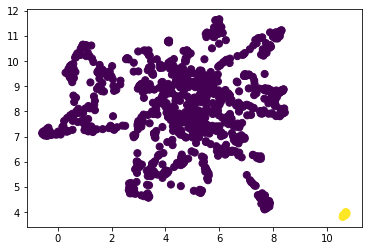

In [170]:
import matplotlib.pyplot as plt

plt.scatter(umap_tfidf[:, 0], umap_tfidf[:, 1], c=y_dbscan, s=50, cmap='viridis')

### Gcash Rating 5

In [171]:
vz = vectorizer.fit_transform(gcash_rating5['title_review'])

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [174]:
svd_model = TruncatedSVD(n_components=30)
svd_tfidf = svd_model.fit_transform(vz)

umap_model = umap.UMAP(n_components=2)
umap_tfidf = umap_model.fit_transform(svd_tfidf)

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [175]:
eps = 2.5 # how close points should be to each other to be considered a part of a cluster, e.g 2.5
min_samples = 15 # the minimum number of points to form a dense region, e.g 15
dbscan = DBSCAN(
eps=eps,
min_samples=min_samples
)
dbscan_model = dbscan.fit(umap_tfidf)

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


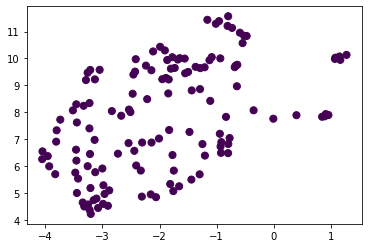

In [176]:
y_dbscan = dbscan_model.labels_

plt.scatter(umap_tfidf[:, 0], umap_tfidf[:, 1], c=y_dbscan, s=50, cmap='viridis')

---
### LDA Topic Modelling <br>
The first part will aim to create a topic model for the Gcash reviews having 1-star ratings. <br>
### A. Gcash Rating 1

In [21]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))

data = gcash_rating1.title_review.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1][0][:30])

['worst', 'customer', 'service', 'ever', 'my', 'old', 'account', 'number', 'was', 'blocked', 'and', 'cannot', 'receive', 'any', 'messages', 'anymore', 'so', 'immediately', 'called', 'the', 'customer', 'service', 'on', 'june', 'about', 'the', 'issue', 'and', 'asked', 'me']


D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Phrase Modeling: Bigram and Trigram Models

In [22]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
#final_stopwords_list

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in final_stopwords_list] for doc in texts]


def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]


def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]


def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
# Remove Stop Words
data_words_nostops1 = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams1 = make_bigrams(data_words_nostops1)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized1 = lemmatization(data_words_bigrams1, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized1[:1])

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['bad', 'customer', 'service', 'old', 'account', 'number', 'block', 'receive', 'message', 'anymore', 'immediately', 'call', 'customer', 'service', 'june', 'issue', 'ask', 'create', 'new', 'account', 'send', 'balance', 'previous', 'account', 'ask', 'detail', 'need', 'email', 'send', 'immediately', 'day', 'july', 'receive', 'email', 'send', 'new', 'account', 'send', 'reference', 'number', 'date', 'tell', 'receive', 'money', 'reference', 'number', 'immediately', 'call', 'customer', 'service', 'calling', 'july', 'answer', 'get', 'heck', 'agent', 'know', 'issue', 'agent', 'manner', 'customer', 'customer', 'service', 'representative', 'etiquette', 'manner']]


### Data Transformation: Corpus and Dictionary

In [25]:
# Create Dictionary
id2word1 = corpora.Dictionary(data_lemmatized1)

# Create Corpus
texts1 = data_lemmatized1

# Term Document Frequency
corpus1 = [id2word1.doc2bow(text) for text in texts1]

# View
print(corpus1[:1])

[[(0, 4), (1, 2), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 5), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 3), (20, 2), (21, 2), (22, 1), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 2), (29, 3), (30, 1), (31, 1), (32, 3), (33, 2), (34, 1), (35, 4), (36, 4), (37, 1)]]


D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Base Model Creation Using TFIDF

In [26]:
tfidf1 = models.TfidfModel(corpus1)
corpus_tfidf1 = tfidf1[corpus1]

# Build LDA model
lda_model_rating1 = gensim.models.LdaMulticore(corpus=corpus_tfidf1,
                                       id2word=id2word1,
                                       num_topics=10, 
                                       random_state=1,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
# Print the keywords in the 10 topics
pprint(lda_model_rating1.print_topics())
doc_lda= lda_model_rating1[corpus_tfidf1]

[(0,
  '0.027*"code" + 0.016*"send" + 0.013*"receive" + 0.012*"try" + 0.010*"log" + '
  '0.009*"number" + 0.009*"time" + 0.009*"poor" + 0.008*"money" + 0.008*"get"'),
 (1,
  '0.009*"trash" + 0.008*"error" + 0.008*"update" + 0.007*"bulok" + '
  '0.006*"log" + 0.006*"ot" + 0.005*"wrong" + 0.005*"stupid" + 0.004*"account" '
  '+ 0.004*"open"'),
 (2,
  '0.006*"cash" + 0.005*"yung" + 0.005*"scammer" + 0.005*"niyo" + '
  '0.005*"update" + 0.004*"bank" + 0.004*"handle" + 0.004*"pera" + '
  '0.004*"account" + 0.004*"kayo"'),
 (3,
  '0.006*"magsend" + 0.004*"order" + 0.004*"payment" + 0.004*"bulok" + '
  '0.004*"naman" + 0.004*"blah" + 0.004*"sept" + 0.004*"apple" + 0.004*"lag" + '
  '0.004*"kayo"'),
 (4,
  '0.007*"code" + 0.005*"verification" + 0.005*"yung" + 0.005*"save" + '
  '0.005*"gcredit" + 0.005*"pin" + 0.005*"gscore" + 0.004*"inconvenience" + '
  '0.004*"withdraw" + 0.004*"authentication"'),
 (5,
  '0.011*"open" + 0.011*"update" + 0.006*"rebate" + 0.006*"stupid" + '
  '0.005*"yung" + 0

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Compute Model Coherence Score

In [28]:
# Compute Coherence Score
coherence_model_lda1 = CoherenceModel(model=lda_model_rating1, texts=data_lemmatized1, dictionary=id2word1, coherence='c_v')
coherence_lda1 = coherence_model_lda1.get_coherence()

print('\nCoherence Score: ', coherence_lda1)

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score:  0.4833182124565855


### Hyperparameter Tuning <br>
This part aims the optimum number of topics and values for eta and alpha.

In [45]:
# supporting function
def compute_coherence_values(data_lemmatized, corpus, dictionary, k, a, eta):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k,
                                           alpha=a,
                                           eta=eta,
                                           random_state=100,
                                           chunksize=100,
                                           passes=10)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Eta parameter
eta = list(np.arange(0.01, 1, 0.3))
eta.append('symmetric')

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
model_results = {'Topics': [],
                 'Alpha': [],
                 'Eta': [],
                 'Coherence': []
                }
# Loop to determine optimal number of topics
if 1 == 1:
    pbar = tqdm.tqdm(total=54)
    
    # iterate through the number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through eta values
            for e in eta:
                cv = compute_coherence_values(data_lemmatized1, 
                                              corpus=corpus_tfidf1, 
                                              dictionary=id2word1, 
                                              k=k,
                                              a=a,
                                              eta=e)
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Eta'].append(e)
                model_results['Coherence'].append(cv)
        
            pbar.update(1)
    
    pd.DataFrame(model_results).to_csv('lda_tuning_results_rating1.csv', index=False)
    pbar.close()

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 1/200 [00:46<2:34:58, 46.73s/it]

  1%|          | 2/200 [01:35<2:37:24, 47.70s/it]

  2%|▏         | 3/200 [02:23<2:36:54, 47.79s/it]

  2%|▏         | 4/200 [03:10<2:35:33, 47.62s/it]

  2%|▎         | 5/200 [03:58<2:35:49, 47.95s/it]

  3%|▎         | 6/200 [04:46<2:35:07, 47.98s/it]

  4%|▎         | 7/200 [05:34<2:33:23, 47.69s/it]

  4%|▍         | 8/200 [06:22<2:33:15, 47.90s/it]

  0%|          | 0/200 [08:11<?, ?it/s]


  5%|▌         | 10/200 [07:58<2:31:39, 47.89s/it]

  6%|▌         | 11/200 [08:46<2:31:13, 48.01s/it]

  6%|▌         | 12/200 [09:33<2:29:37

In [50]:
lda_tuning_results_rating1= pd.read_csv('lda_tuning_results_rating1.csv')

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
lda_tuning_results_rating1.sort_values(by='Coherence', ascending=False)

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topics,Alpha,Eta,Coherence
118,5,asymmetric,0.9099999999999999,0.733527
207,8,asymmetric,0.61,0.710479
208,8,asymmetric,0.9099999999999999,0.697759
117,5,asymmetric,0.61,0.679988
237,9,asymmetric,0.61,0.611178
...,...,...,...,...
168,7,0.9099999999999999,0.9099999999999999,0.213413
27,2,asymmetric,0.61,0.211423
253,10,0.61,0.9099999999999999,0.208435
223,9,0.61,0.9099999999999999,0.207025


### Final Model

In [55]:
final_lda1 = gensim.models.LdaMulticore(corpus=corpus1,
                                           id2word=id2word1,
                                           num_topics=5, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha='asymmetric',
                                           eta=0.9099999999999999)

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = gensimvis.prepare(final_lda1, corpus1, id2word1)
LDAvis_prepared

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.122922 -0.023379       1        1  66.822950
1      0.025378  0.054730       2        1  14.836065
2     -0.059088 -0.031287       3        1  10.008225
3     -0.036890 -0.023794       4        1   6.525185
4     -0.052322  0.023731       5        1   1.807575, topic_info=           Term        Freq       Total Category  logprob  loglift
268           d   72.000000   72.000000  Default  30.0000  30.0000
26        money  157.000000  157.000000  Default  29.0000  29.0000
276     student   39.000000   39.000000  Default  28.0000  28.0000
649        yung   61.000000   61.000000  Default  27.0000  27.0000
329           i   35.000000   35.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
2428     parang    0.285160    3.347825   Topic5  -6.9163   1.5502
912   available    0.335995   17.296311   Topic5  -6.7523   0.0720
365     paymaya    0.315618   23.605479   Topic5  -6.8149  -0.3015
569        pera    0.287833   41.850438   Topic5  -6.9070  -0.9663
1551         ok    0.285125    3.497069   Topic5  -6.9165   1.5064

[304 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
129       1  0.930460   access
129       2  0.037218   access
0         1  0.864480  account
0         2  0.114676  account
0         3  0.017642  account
...     ...       ...      ...
1021      4  0.074274      yun
649       1  0.508023     yung
649       2  0.016388     yung
649       3  0.393308     yung
649       4  0.081939     yung

[577 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

---
### B. Gcash Rating 5
This part will aim to create a topic model for the Gcash reviews having 5-star ratings. <br>

In [57]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))

data = gcash_rating5.title_review.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1][0][:30])

['gcash', 'user', 'since', 'have', 'been', 'using', 'gcash', 'for', 'years', 'now', 'and', 'yes', 'it', 'is', 'not', 'perfect', 'but', 'it', 'has', 'helped', 'me', 'lot', 'in', 'managing', 'my', 'finances', 'especially', 'now', 'that', 'there']


D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Phrase Modeling: Bigram and Trigram Models

In [58]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [59]:
#final_stopwords_list

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in final_stopwords_list] for doc in texts]


def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]


def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]


def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:
# Remove Stop Words
data_words_nostops5 = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams5 = make_bigrams(data_words_nostops5)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized5 = lemmatization(data_words_bigrams5, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized5[:1])

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['user', 'year', 'perfect', 'help', 'lot', 'manage', 'finance', 'especially', 'pandemic', 'want', 'transfer', 'different', 'bank', 'easy', 'able', 'pay', 'bill', 'home', 'connect', 'bank', 'account', 'cash', 'happen', 'real', 'time', 'encounter', 'issue', 'unsuccessful', 'transaction', 'money', 'deduct', 'account', 'error', 'pay', 'bill', 'usually', 'pay', 'month', 'believe', 'minor', 'lapse', 'able', 'address', 'case', 'money', 'deduct', 'return', 'able', 'pay', 'bill', 'retrying', 'time', 'mention', 'gsave', 'partner', 'cimb', 'annum', 'interest', 'rate', 'waaaay', 'bank', 'offer', 'summary', 'believe', 'great', 'use', 'ahead', 'download']]


### Data Transformation: Corpus and Dictionary

In [61]:
# Create Dictionary
id2word5 = corpora.Dictionary(data_lemmatized5)

# Create Corpus
texts5 = data_lemmatized5

# Term Document Frequency
corpus5 = [id2word5.doc2bow(text) for text in texts5]

# View
print(corpus5[:1])

[[(0, 3), (1, 2), (2, 1), (3, 1), (4, 1), (5, 3), (6, 2), (7, 3), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 2), (33, 1), (34, 1), (35, 1), (36, 1), (37, 4), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 2), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1)]]


D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Base Model Creation Using TFIDF

In [62]:
tfidf5 = models.TfidfModel(corpus5)
corpus_tfidf5 = tfidf5[corpus5]

# Build LDA model
lda_model_rating5 = gensim.models.LdaMulticore(corpus=corpus_tfidf5,
                                       id2word=id2word5,
                                       num_topics=10, 
                                       random_state=1,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [63]:
# Print the keywords in the 10 topics
pprint(lda_model_rating5.print_topics())
doc_lda= lda_model_rating5[corpus_tfidf5]

[(0,
  '0.018*"well" + 0.008*"life" + 0.008*"bank" + 0.008*"request" + '
  '0.007*"money" + 0.007*"love" + 0.007*"bill" + 0.007*"get" + 0.007*"invest" '
  '+ 0.007*"limit"'),
 (1,
  '0.022*"good" + 0.011*"year" + 0.011*"like" + 0.009*"io" + 0.008*"nice" + '
  '0.008*"fully" + 0.007*"account" + 0.007*"pay" + 0.007*"nickname" + '
  '0.007*"allow"'),
 (2,
  '0.010*"amazing" + 0.008*"limit" + 0.008*"basta" + 0.007*"create" + '
  '0.007*"gamitin" + 0.007*"receive" + 0.006*"great" + 0.006*"problem" + '
  '0.006*"exceed" + 0.006*"nice"'),
 (3,
  '0.018*"helpful" + 0.011*"verify" + 0.010*"convenience" + 0.010*"good" + '
  '0.009*"omsim" + 0.008*"smart" + 0.008*"app" + 0.007*"everyday" + '
  '0.007*"superb" + 0.006*"continuously"'),
 (4,
  '0.012*"update" + 0.009*"number" + 0.009*"fix" + 0.008*"gcredit" + '
  '0.008*"maasahan" + 0.008*"good" + 0.008*"awesome" + 0.008*"love" + '
  '0.007*"convenient" + 0.007*"send"'),
 (5,
  '0.009*"payment" + 0.009*"user" + 0.009*"bank" + 0.009*"bill" + 0.008*"

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Compute Model Coherence Score

In [64]:
# Compute Coherence Score
coherence_model_lda5 = CoherenceModel(model=lda_model_rating5, texts=data_lemmatized5, dictionary=id2word5, coherence='c_v')
coherence_lda5 = coherence_model_lda5.get_coherence()

print('\nCoherence Score: ', coherence_lda5)

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score:  0.5131580130068361


### Hyperparameter Tuning <br>
This part aims the optimum number of topics and values for eta and alpha.

In [65]:
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Eta parameter
eta = list(np.arange(0.01, 1, 0.3))
eta.append('symmetric')

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [66]:
model_results = {'Topics': [],
                 'Alpha': [],
                 'Eta': [],
                 'Coherence': []
                }
# Loop to determine optimal number of topics
if 1 == 1:
    pbar = tqdm.tqdm(total=54)
    
    # iterate through the number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through eta values
            for e in eta:
                cv = compute_coherence_values(data_lemmatized5, 
                                              corpus=corpus_tfidf5, 
                                              dictionary=id2word5, 
                                              k=k,
                                              a=a,
                                              eta=e)
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Eta'].append(e)
                model_results['Coherence'].append(cv)
        
            pbar.update(1)
    
    pd.DataFrame(model_results).to_csv('lda_tuning_results_rating5.csv', index=False)
    pbar.close()

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 54/54 [14:02<00:00, 15.60s/it]


In [67]:
lda_tuning_results_rating5= pd.read_csv('lda_tuning_results_rating5.csv')

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [68]:
lda_tuning_results_rating5.sort_values(by='Coherence', ascending=False)

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topics,Alpha,Eta,Coherence
207,8,asymmetric,0.61,0.696336
177,7,asymmetric,0.61,0.689220
206,8,asymmetric,0.31,0.687147
118,5,asymmetric,0.9099999999999999,0.679545
87,4,asymmetric,0.61,0.678953
...,...,...,...,...
192,8,0.61,0.61,0.328861
137,6,0.9099999999999999,0.61,0.324410
107,5,0.9099999999999999,0.61,0.319405
103,5,0.61,0.9099999999999999,0.319405


### Final Model

In [69]:
final_lda5 = gensim.models.LdaMulticore(corpus=corpus5,
                                           id2word=id2word5,
                                           num_topics=8, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha='asymmetric',
                                           eta=0.61)

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [70]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = gensimvis.prepare(final_lda5, corpus5, id2word5)
LDAvis_prepared

D:\Anaconda3\envs\project-env-2\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.075535  0.028291       1        1  45.759574
1      0.030188 -0.054763       2        1  25.716874
2     -0.017280  0.011844       3        1  10.960204
7     -0.015427  0.006695       4        1   4.996362
5     -0.023519  0.005847       5        1   4.473425
6     -0.017685  0.003228       6        1   3.990576
3     -0.015612  0.000466       7        1   2.850333
4     -0.016199 -0.001608       8        1   1.252651, topic_info=            Term       Freq      Total Category  logprob  loglift
131         good  14.000000  14.000000  Default  30.0000  30.0000
152         love  10.000000  10.000000  Default  29.0000  29.0000
238       number   9.000000   9.000000  Default  28.0000  28.0000
118         send  10.000000  10.000000  Default  27.0000  27.0000
32         money  16.000000  16.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
45   transaction   0.032008  16.539322   Topic8  -6.5712  -1.8676
44          time   0.031867   9.408292   Topic8  -6.5756  -1.3079
74        people   0.031781   3.726831   Topic8  -6.5783  -0.3845
83         thing   0.031762   3.085426   Topic8  -6.5789  -0.1963
86           try   0.031758   6.027096   Topic8  -6.5791  -0.8660

[432 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.507037      able
0         2  0.338025      able
1         1  0.589139   account
1         2  0.294570   account
192       3  0.514593  actually
...     ...       ...       ...
461       3  0.618107   worried
143       1  0.856513     wrong
53        1  0.466567      year
53        2  0.155522      year
53        3  0.155522      year

[309 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 8, 6, 7, 4, 5])